In [1]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import LancasterStemmer
stemmer = LancasterStemmer()

def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(stemmer.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [2]:
import re
def preprocessing(line):
    line = re.sub(r'[^a-zA-z.?!\']', ' ', line)
    line = re.sub(r'[ ]+', ' ', line)
    return line

In [3]:
import pandas as pd
df = pd.read_json('./intent.json')
df.head()

,intent,text,responses,extension,context,entityType,entities
0,Greeting,"[Hi, Hi there, Hola, Hello, Hello there, Hya, ...","[Hi human, please tell me your GeniSys user, H...","{'function': '', 'entities': False, 'responses...","{'in': '', 'out': 'GreetingUserRequest', 'clea...",NA,[]
1,GreetingResponse,"[My user is Adam, This is Adam, I am Adam, It ...","[Great! Hi <HUMAN>! How can I help?, Good! Hi ...","{'function': 'extensions.gHumans.updateHuman',...","{'in': 'GreetingUserRequest', 'out': '', 'clea...",NA,"[{'entity': 'HUMAN', 'rangeFrom': 3, 'rangeTo'..."
2,CourtesyGreeting,"[How are you?, Hi how are you?, Hello how are ...","[Hello, I am great, how are you? Please tell m...","{'function': '', 'entities': False, 'responses...","{'in': '', 'out': 'CourtesyGreetingUserRequest...",NA,[]
3,CourtesyGreetingResponse,"[Good thanks! My user is Adam, Good thanks! Th...","[Great! Hi <HUMAN>! How can I help?, Good! Hi ...","{'function': 'extensions.gHumans.updateHuman',...","{'in': 'GreetingUserRequest', 'out': '', 'clea...",NA,"[{'entity': 'HUMAN', 'rangeFrom': 5, 'rangeTo'..."
4,CurrentHumanQuery,"[What is my name?, What do you call me?, Who d...","[You are <HUMAN>! How can I help?, Your name i...",{'function': 'extensions.gHumans.getCurrentHum...,"{'in': '', 'out': 'CurrentHumanQuery', 'clear'...",NA,[]


In [4]:
intent = []
for field in df.values:
    for text in field[1]:
        intent.append({'intent':field[0], 'caption':preprocessing(text)})
df = pd.DataFrame(intent)
df.head()

,intent,caption
0,Greeting,Hi
1,Greeting,Hi there
2,Greeting,Hola
3,Greeting,Hello
4,Greeting,Hello there


In [5]:
print(', '.join(set(df['intent'])))

UnderstandQuery, CourtesyGreetingResponse, Gossip, CurrentHumanQuery, Jokes, NameQuery, Clever, GoodBye, Shutup, Thanks, PodBayDoor, RealNameQuery, PodBayDoorResponse, GreetingResponse, TimeQuery, Greeting, CourtesyGoodBye, NotTalking2U, Swearing, WhoAmI, SelfAware, CourtesyGreeting


In [6]:
from nltk.stem import LancasterStemmer
stemmer = LancasterStemmer()
df['caption'] = df['caption'].apply(stemSentence)
df['caption'].head()

0            hi 
1       hi ther 
2           hol 
3         hello 
4    hello ther 
Name: caption, dtype: object

In [7]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(filters='', oov_token='<unk>')
tokenizer.fit_on_texts(df['caption'])

In [8]:
vocab_size = len(tokenizer.word_index)+1
maxlen = len(max(df['caption'], key = len))
print(vocab_size, maxlen)

117 36


In [9]:
from keras.preprocessing.sequence import pad_sequences
encoded = tokenizer.texts_to_sequences(df['caption'])
padded = pad_sequences(encoded, maxlen = maxlen, padding = "pre")
padded.shape

(143, 36)

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
le = LabelEncoder()
intents = le.fit_transform(df['intent'])
intents = intents.reshape(-1,1)
intents = ohe.fit_transform(intents).toarray()
intents.shape

(143, 22)

In [11]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(padded, intents, test_size = 0.2)
print(train_X.shape, train_Y.shape)
print(test_X.shape, test_Y.shape)

(114, 36) (114, 22)
(29, 36) (29, 22)


In [12]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout
model = Sequential()
model.add(Embedding(vocab_size, 512))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(22, activation = "softmax"))
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 512)         59904     
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               656384    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 22)                2838      
Total params: 752,022
Trainable params: 752,022
Non-trainable params: 0
_________________________________________________________________


In [13]:
from keras.callbacks import EarlyStopping 
es_callback = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(train_X, train_Y,
                    epochs = 50, 
                    validation_data=(test_X, test_Y), 
                    batch_size=32,
                    callbacks=[es_callback])

Epoch 1/50
4/4 [==============================] - 3s 856ms/step - loss: 3.0910 - accuracy: 0.0526 - val_loss: 3.0955 - val_accuracy: 0.0690
Epoch 2/50
4/4 [==============================] - 1s 247ms/step - loss: 3.0751 - accuracy: 0.0614 - val_loss: 3.1057 - val_accuracy: 0.0690
Epoch 3/50
4/4 [==============================] - 1s 206ms/step - loss: 3.0607 - accuracy: 0.0789 - val_loss: 3.0974 - val_accuracy: 0.0000e+00
Epoch 4/50
4/4 [==============================] - 1s 216ms/step - loss: 3.0347 - accuracy: 0.0965 - val_loss: 3.0575 - val_accuracy: 0.0690
Epoch 5/50
4/4 [==============================] - 1s 221ms/step - loss: 2.9841 - accuracy: 0.1754 - val_loss: 3.0296 - val_accuracy: 0.1379
Epoch 6/50
4/4 [==============================] - 1s 241ms/step - loss: 2.9500 - accuracy: 0.1754 - val_loss: 2.9987 - val_accuracy: 0.1034
Epoch 7/50
4/4 [==============================] - 1s 256ms/step - loss: 2.8527 - accuracy: 0.2193 - val_loss: 2.9317 - val_accuracy: 0.1379
Epoch 8/50
4/4 [

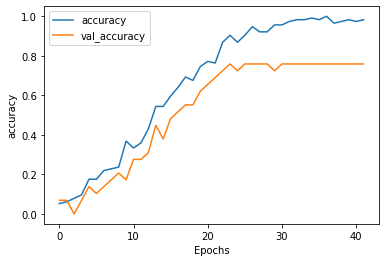

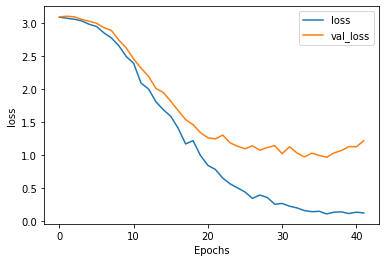

In [14]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [33]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [39]:
message = input("Enter message: ")
stemmed = stemSentence(message)
encoded = tokenizer.texts_to_sequences([stemmed])
padded = pad_sequences(encoded, maxlen=maxlen, padding="pre")
result = ohe.inverse_transform(model(padded))
le.inverse_transform(result)[0]

Enter message: what is your name


'NameQuery'